In [1]:
%matplotlib inline

In [2]:
#
# We need a regression model for predicting methylation (highest priority): 
# Variables are: 
#   - Number of unique CpGs per cell
#   - Median Average Read CpG per cell (or mean if normally distributed)
#   - BS rate per cell
#   - CLL or Normal status per cell
# What is the coefficient and the P value for each variable for a model predicting methylation?

In [3]:
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm
pd.set_option('display.max_columns', 50) # print all rows


import os
os.chdir('/Users/evanbiederstedt/Downloads/RRBS_data_files')

In [4]:
normal_cellA_df = pd.read_csv("Meth_PDR_cell_RRBS_normal_B1.csv")
normal_cellB_df = pd.read_csv("Meth_PDR_cell_normalpcell.csv")
normal_cellC_df = pd.read_csv("Meth_PDR_cell_normal_mcell.csv")
cll_cellA_df = pd.read_csv("Meth_PDR_cell_CLL_RRBS_cw154_A.csv")
cll_cellC_df = pd.read_csv("Meth_PDR_cell_CLL_RRBS_trito_pool_C.csv")

In [5]:
normal_cellA_df = normal_cellA_df.drop(["Unnamed: 0"], axis=1)  
normal_cellA_df["type"] = str('normal')
normal_cellA_df["bio"] = str('normal_B')
normal_cellA_df["protocol"] = normal_cellA_df["filename"].str[5:24]
normal_cellA_df["filename"] = normal_cellA_df["filename"].str[:40]

In [6]:
normal_cellA_df.head()

,filename,methylation,PDR_total,thisMeth,mixedReadCount,total_reads,type,bio,protocol
0,RRBS_normal_B_cell_A1_24_TAAGGCGA.ACAACC,0.584639,0.271471,1142525.0,530519.0,1954240.0,normal,normal_B,normal_B_cell_A1_24
1,RRBS_normal_B_cell_A1_24_TAAGGCGA.ACCGCG,0.524969,0.435593,318935.0,264636.0,607531.0,normal,normal_B,normal_B_cell_A1_24
2,RRBS_normal_B_cell_A1_24_TAAGGCGA.ACGTGG,0.560134,0.280063,978219.0,489103.0,1746403.0,normal,normal_B,normal_B_cell_A1_24
3,RRBS_normal_B_cell_A1_24_TAAGGCGA.ACTCAC,0.613036,0.423883,1345.0,930.0,2194.0,normal,normal_B,normal_B_cell_A1_24
4,RRBS_normal_B_cell_A1_24_TAAGGCGA.AGGATG,0.607458,0.253306,2177284.0,907915.0,3584255.0,normal,normal_B,normal_B_cell_A1_24


In [7]:
cpg1 = pd.read_csv('Meth_PDR_cell_RRBS_normal_B1_CpGs.csv')
cpg1 = cpg1.drop(["Unnamed: 0"], axis=1)  
cpg1["filename"] = cpg1["filename"].str[:40]
normal_cellA_df = pd.merge(normal_cellA_df, cpg1, how='inner')
normal_cellB_df["type"] = str('normal')
normal_cellB_df = normal_cellB_df.drop(["Unnamed: 0"], axis=1) 
normal_cellB_df["bio"] = str('CD27p')
normal_cellB_df["protocol"] = normal_cellB_df["filename"].str[5:31]
normal_cellB_df["filename"] = normal_cellB_df["filename"].str[:50]
normal_cellB_df["filename"] = normal_cellB_df["filename"].str.replace(r'.dan$', '')
normal_cellB_df["filename"] = normal_cellB_df["filename"].str.replace(r'.da$', '')
cpg2 = pd.read_csv('RRBS_NormalBCD19pCD27pcell_CpGs.csv')
cpg2 = cpg2.drop(["Unnamed: 0"], axis=1)  
cpg2["filename"] = cpg2["filename"].str[:50]
cpg2["filename"] = cpg2["filename"].str.replace(r'.dan$', '')
cpg2["filename"] = cpg2["filename"].str.replace(r'.da$', '')
normal_cellB_df = pd.merge(normal_cellB_df, cpg2, how='inner')
normal_cellC_df = normal_cellC_df.drop(["Unnamed: 0"], axis=1)  
normal_cellC_df["type"] = str('normal')
normal_cellC_df["protocol"] = normal_cellC_df["filename"].str[5:31]
normal_cellC_df["bio"] = str('CD27m')
normal_cellC_df["filename"] = normal_cellC_df["filename"].str[:50]
normal_cellC_df["filename"] = normal_cellC_df["filename"].str.replace(r'.dan$', '')
normal_cellC_df["filename"] = normal_cellC_df["filename"].str.replace(r'.da$', '')
cpg3 = pd.read_csv("RRBS_NormalBCD19pCD27mcell_CpGs.csv")
cpg3 = cpg3.drop(["Unnamed: 0"], axis=1)  
cpg3["filename"] = cpg3["filename"].str[:50]
cpg3["filename"] = cpg3["filename"].str.replace(r'.dan$', '')
cpg3["filename"] = cpg3["filename"].str.replace(r'.da$', '')
normal_cellC_df = pd.merge(normal_cellC_df, cpg3, how='inner')
frames3 = [normal_cellA_df, normal_cellB_df, normal_cellC_df]
normal_result = pd.concat(frames3)
print(normal_result.shape)
print(normal_result.columns)

(304, 11)
Index(['PDR_total', 'avgReadCpGs_mean', 'avgReadCpGs_median', 'bio',
       'filename', 'methylation', 'mixedReadCount', 'protocol', 'thisMeth',
       'total_reads', 'type'],
      dtype='object')


In [8]:
normal_result = normal_result[['filename', 'methylation', 'total_reads', 'type', 'bio', 'protocol', 'avgReadCpGs_mean', 'avgReadCpGs_median']]

In [9]:
cll_cellA_df = cll_cellA_df.drop(["Unnamed: 0"], axis=1) 
cll_cellA_df["type"] = str('CLL')
cll_cellA_df["protocol"] = cll_cellA_df["filename"].str[5:34]
cll_cellA_df["protocol"][cll_cellA_df["protocol"] == 'cw154_CutSmart_proteinase_K_T'] = 'cw154_CutSmart_proteinase_K'
cll_cellA_df["protocol"][cll_cellA_df["protocol"] == 'cw154_Tris_protease_GR_CAGAGA'] = 'cw154_Tris_protease_GR'
cll_cellA_df["protocol"][(cll_cellA_df["protocol"] != 
        'cw154_Tris_protease_GR') & (cll_cellA_df["protocol"] != 'cw154_CutSmart_proteinase_K')] = 'cw154_Tris_protease'
cll_cellA_df["bio"] = str('CLL')
cll_cellA_df["filename"] = cll_cellA_df["filename"].str[:51]
cll_cellA_df["filename"] = cll_cellA_df["filename"].str.replace(r'.da$', '')
cll_cellA_df["filename"] = cll_cellA_df["filename"].str.replace(r'.annoRR$', '')
cll_cellA_df["filename"] = cll_cellA_df["filename"].str.replace(r'.ann$', '')
cll_cellA_df["filename"] = cll_cellA_df["filename"].str.replace(r'.dan$', '')
cpg4 = pd.read_csv('CLL_RRBS_cw154_A_CpGs.csv')
cpg4 = cpg4.drop(["Unnamed: 0"], axis=1)  
cpg4["filename"] = cpg4["filename"].str[:51]
cpg4["filename"] = cpg4["filename"].str.replace(r'.da$', '')
cpg4["filename"] = cpg4["filename"].str.replace(r'.annoRR$', '')
cpg4["filename"] = cpg4["filename"].str.replace(r'.ann$', '')
cpg4["filename"] = cpg4["filename"].str.replace(r'.dan$', '')
cll_cellA_df = pd.merge(cll_cellA_df, cpg4, how='inner')
cll_cellC_df = cll_cellC_df.drop(["Unnamed: 0"], axis=1) 
cll_cellC_df["type"] = str('CLL')
cll_cellC_df["bio"] = str('CLL')
cll_cellC_df["protocol"] = cll_cellC_df["filename"].str[5:17]
cll_cellC_df["filename"] = cll_cellC_df["filename"].str[:33]
cpg5 = pd.read_csv('Meth_PDR_cell_RRBS_trito_pool_CpGs.csv')
cpg5 = cpg5.drop(["Unnamed: 0"], axis=1) 
cpg5["filename"] = cpg5["filename"].str[:33]
cll_cellC_df = pd.merge(cll_cellC_df, cpg5, how='inner')
frames2 = [cll_cellA_df, cll_cellC_df]
cll_result = pd.concat(frames2)
print(cll_result.shape)
print(cll_result.columns)

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(110, 11)
Index(['PDR_total', 'avgReadCpGs_mean', 'avgReadCpGs_median', 'bio',
       'filename', 'methylation', 'mixedReadCount', 'protocol', 'thisMeth',
       'total_reads', 'type'],
      dtype='object')


In [10]:
cll_result = cll_result[['filename', 'methylation', 'total_reads', 'type', 'bio', 'protocol', 'avgReadCpGs_mean', 'avgReadCpGs_median']]
cll_result = cll_result.reset_index(drop=True)
normal_result = normal_result.reset_index(drop=True)
combined2 = normal_result.append(cll_result)
combined2 = combined2.reset_index(drop=True)
combined2.head()

,filename,methylation,total_reads,type,bio,protocol,avgReadCpGs_mean,avgReadCpGs_median
0,RRBS_normal_B_cell_A1_24_TAAGGCGA.ACAACC,0.584639,1954240.0,normal,normal_B,normal_B_cell_A1_24,5.295301,4.0
1,RRBS_normal_B_cell_A1_24_TAAGGCGA.ACCGCG,0.524969,607531.0,normal,normal_B,normal_B_cell_A1_24,5.285714,4.0
2,RRBS_normal_B_cell_A1_24_TAAGGCGA.ACGTGG,0.560134,1746403.0,normal,normal_B,normal_B_cell_A1_24,5.453122,5.0
3,RRBS_normal_B_cell_A1_24_TAAGGCGA.ACTCAC,0.613036,2194.0,normal,normal_B,normal_B_cell_A1_24,4.950166,4.0
4,RRBS_normal_B_cell_A1_24_TAAGGCGA.AGGATG,0.607458,3584255.0,normal,normal_B,normal_B_cell_A1_24,5.366276,5.0


In [11]:
bs = pd.read_table('allStats.txt')
bs = bs.drop('sample.1', axis=1)
bs = bs.drop('sample.2', axis=1)
bs = bs.reset_index(drop=True)
bs = bs.drop('class', axis=1)
bs = bs.drop('totMeth', axis=1)
bs = bs.drop('totSeen', axis=1)
bs = bs.drop('avSum', axis=1)
bs = bs.drop('avTot', axis=1)
bs = bs.drop('rMixed', axis=1)
bs = bs.drop('rTot', axis=1)
bs = bs.drop('rAv', axis=1)
bs = bs.drop('rAvTot', axis=1)
bs = bs.drop('bed', axis=1)
bs = bs.drop('methInfoFile', axis=1)
bs = bs.drop('totReads', axis=1)
bs = bs.drop('totAligned', axis=1)
bs = bs.drop('totClipped', axis=1)
bs = bs.drop('totSeenCpG', axis=1)
bs = bs.drop('totUsed', axis=1)
bs = bs.drop('totMethCpG', axis=1)
# bs = bs.drop('totCpG', axis=1)
bs = bs.drop('totalReadPairs', axis=1)
bs = bs.drop('alignedReads', axis=1)
bs = bs.drop('totalReads', axis=1)
bs = bs.rename(columns = {'sample':'filename'})

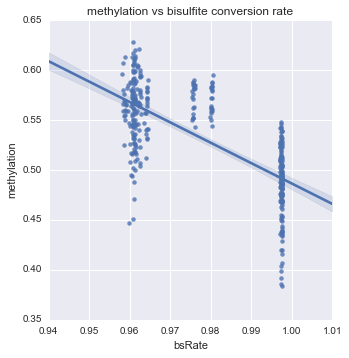

In [12]:
merged = pd.merge(combined2, bs, how='inner')
merged = merged.reset_index(drop=True)
merged = merged.rename(columns = {'totCpG':'Unique_CpGs'})
# Remove all data points with less than 100k in totcpg 
merged = merged[merged['total_reads'] > 100000]
scattermatrix1 = merged.drop(['filename', 'total_reads', 'type', 'protocol', 'avgReadCpGs_median'], axis=1)
sns.lmplot(x="bsRate", y="methylation",  data=scattermatrix1)
plt.title("methylation vs bisulfite conversion rate")

In [13]:
scattermatrix7 = merged.drop(['filename', 'bio', 'avgReadCpGs_median'], axis=1)
y = scattermatrix7.methylation # dependent variable
print(y.shape)
X = scattermatrix7.drop(['methylation', 'total_reads', 'protocol'], axis=1)
print(X.shape)

categorical_variables = ['type']
for variable in categorical_variables:
    # Fill missing data with the word "Missing"
    X[variable].fillna("Missing", inplace=True)
    # Create array of dummies
    dummies = pd.get_dummies(X[variable], prefix=variable)
    # Update X to include dummies and drop the main variable
    X = pd.concat([X, dummies], axis=1)
    X.drop([variable], axis=1, inplace=True)
    
import statsmodels.api as sm
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for CLL 'RRBS_trito_pool1', predict methylation")
print("Variables: Number of unique CpGs per cell, mean Average Read CpG per cell, BS rate, Cll or Normal B")
est.summary()

(357,)
(357, 4)
Regression results for CLL 'RRBS_trito_pool1', predict methylation
Variables: Number of unique CpGs per cell, mean Average Read CpG per cell, BS rate, Cll or Normal B


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            methylation   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     277.5
Date:                Thu, 07 Jul 2016   Prob (F-statistic):          1.98e-107
Time:                        17:31:26   Log-Likelihood:                 821.01
No. Observations:                 357   AIC:                            -1632.
Df Residuals:                     352   BIC:                            -1613.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const                1.8313      0.065     27.993      0.000         1.703     1.960
avgReadCpGs_mean    -0.1059      0.010    -10.707      0.000        -0.125    -0.086
Unique_CpGs       9.175e-08   5.45e-09     16.820      0.000       8.1e-08  1.02e-07
bsRate              -1.7279      0.083    -20.898      0.000        -1.891    -1.565
type_CLL             0.9166      0.032     28.278      0.000         0.853     0.980
type_normal          0.9146      0.033     27.649      0.000         0.850     0.980
==============================================================================
Omnibus:                       12.053   Durbin-Watson:                   1.529
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.871
Skew:                          -0.348   Prob(JB):                     0.000973
Kurtosis:                       3.669   Cond. No.                     8.10e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.76e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [14]:
tritopool = merged[merged["protocol"] == 'trito_pool_1']
tritopool = tritopool.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
tritopoolA = tritopool.set_index("filename")
from itertools import combinations
cc = list(combinations(tritopool.filename,2))
out = pd.DataFrame([tritopoolA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(tritopool.methylation, tritopool.methylation)), tritopool.filename, tritopool.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs = pd.merge(out, methylation_differences, how='inner')
print(pairs.shape)
pairs = pairs.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs.methylation_difference # dependent variable
X = pairs.drop(['methylation', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
print(y.shape)
print(X.shape)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for CLL 'RRBS_trito_pool1', predict \delta methylation")
est.summary()

(210, 7)
(210,)
(210, 3)
Regression results for CLL 'RRBS_trito_pool1', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.048
Model:                                OLS   Adj. R-squared:                  0.034
Method:                     Least Squares   F-statistic:                     3.477
Date:                    Thu, 07 Jul 2016   Prob (F-statistic):             0.0169
Time:                            17:31:26   Log-Likelihood:                 644.72
No. Observations:                     210   AIC:                            -1281.
Df Residuals:                         206   BIC:                            -1268.
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const              -32.6670     10.879     -3.003      0.003       -54.115   -11.219
avgReadCpGs_mean    -0.0053      0.015     -0.361      0.719        -0.034     0.024
Unique_CpGs_mean -2.338e-08   1.03e-08     -2.279      0.024     -4.36e-08 -3.16e-09
bsRate_mean         33.3941     11.087      3.012      0.003        11.536    55.253
==============================================================================
Omnibus:                       20.439   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                9.305
Skew:                           0.302   Prob(JB):                      0.00954
Kurtosis:                       2.164   Cond. No.                     1.72e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.72e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


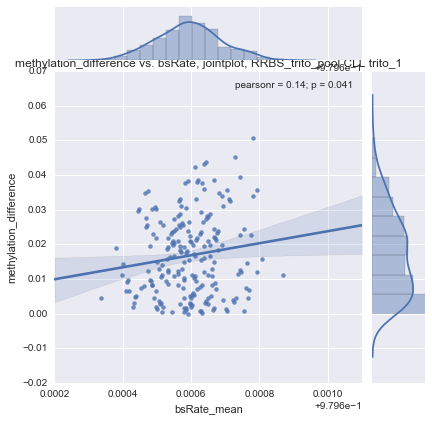

In [15]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, RRBS_trito_pool CLL trito_1")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


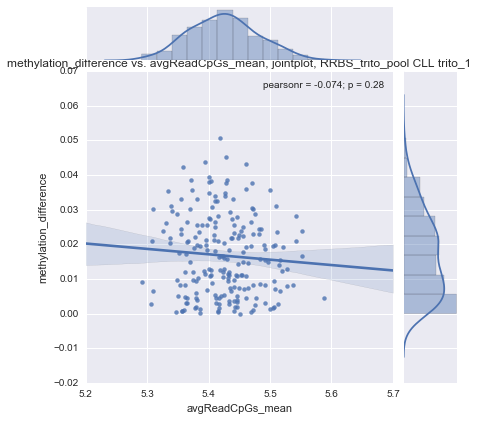

In [16]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, RRBS_trito_pool CLL trito_1")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


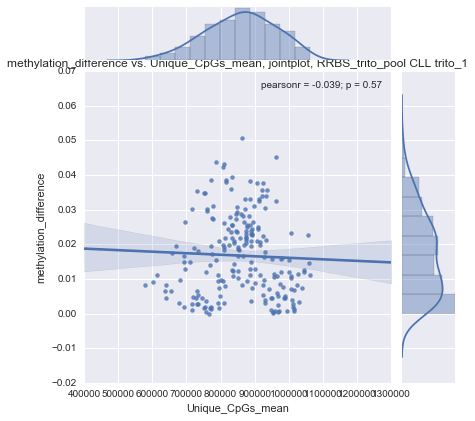

In [17]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, RRBS_trito_pool CLL trito_1")

In [18]:
tritopool2 = merged[merged["protocol"] == 'trito_pool_2']
tritopool2 = tritopool2.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
tritopool2A = tritopool2.set_index("filename")
from itertools import combinations
cc = list(combinations(tritopool2.filename,2))
out = pd.DataFrame([tritopool2A.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(tritopool2.methylation, tritopool2.methylation)), tritopool2.filename, tritopool2.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs1a = pd.merge(out, methylation_differences, how='inner')
print(pairs1a.shape)
pairs1a = pairs1a.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs1a.methylation_difference # dependent variable
X = pairs1a.drop(['methylation', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
print(y.shape)
print(X.shape)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for CLL 'RRBS_trito_pool_2', predict \delta methylation")
est.summary()

(253, 7)
(253,)
(253, 3)
Regression results for CLL 'RRBS_trito_pool_2', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.096
Model:                                OLS   Adj. R-squared:                  0.085
Method:                     Least Squares   F-statistic:                     8.809
Date:                    Thu, 07 Jul 2016   Prob (F-statistic):           1.43e-05
Time:                            17:31:29   Log-Likelihood:                 760.55
No. Observations:                     253   AIC:                            -1513.
Df Residuals:                         249   BIC:                            -1499.
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const                6.0708      7.399      0.820      0.413        -8.503    20.644
avgReadCpGs_mean     0.0397      0.015      2.672      0.008         0.010     0.069
Unique_CpGs_mean -2.951e-08   6.15e-09     -4.801      0.000     -4.16e-08 -1.74e-08
bsRate_mean         -6.3992      7.619     -0.840      0.402       -21.405     8.606
==============================================================================
Omnibus:                       46.589   Durbin-Watson:                   2.082
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               12.752
Skew:                           0.235   Prob(JB):                      0.00170
Kurtosis:                       2.005   Cond. No.                     1.24e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.24e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


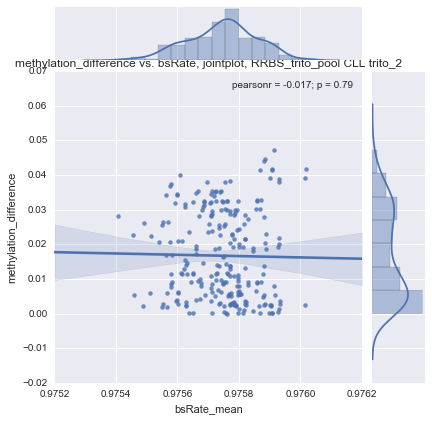

In [19]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs1a, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, RRBS_trito_pool CLL trito_2")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


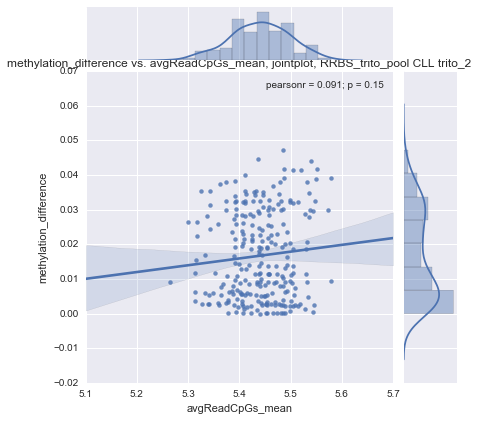

In [20]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs1a, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, RRBS_trito_pool CLL trito_2")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


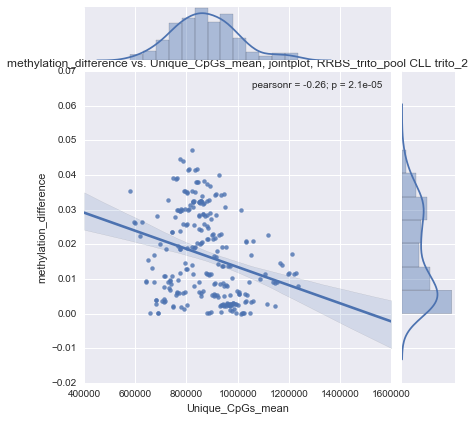

In [21]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs1a, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, RRBS_trito_pool CLL trito_2")

In [22]:
cw154 = merged[merged["protocol"] == 'cw154_Tris_protease']
cw154 = cw154.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
cw154 = cw154.reset_index(drop=True)
cw154A = cw154.set_index("filename")
from itertools import combinations
cc = list(combinations(cw154.filename,2))
out = pd.DataFrame([cw154A.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(cw154.methylation, cw154.methylation)), cw154.filename, cw154.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs2 = pd.merge(out, methylation_differences, how='inner')
pairs2 = pairs2.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs2.methylation_difference # dependent variable
X = pairs2.drop(['methylation', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for CLL 'cw154_Tris_protease', predict \delta methylation")
est.summary()

Regression results for CLL 'cw154_Tris_protease', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.149
Model:                                OLS   Adj. R-squared:                  0.137
Method:                     Least Squares   F-statistic:                     12.06
Date:                    Thu, 07 Jul 2016   Prob (F-statistic):           2.63e-07
Time:                            17:31:32   Log-Likelihood:                 447.77
No. Observations:                     210   AIC:                            -887.5
Df Residuals:                         206   BIC:                            -874.2
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const               28.2209     12.991      2.172      0.031         2.609    53.833
avgReadCpGs_mean     0.0457      0.026      1.744      0.083        -0.006     0.097
Unique_CpGs_mean -7.492e-08   1.85e-08     -4.041      0.000     -1.11e-07 -3.84e-08
bsRate_mean        -29.5513     13.597     -2.173      0.031       -56.358    -2.745
==============================================================================
Omnibus:                       16.429   Durbin-Watson:                   1.221
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.074
Skew:                           0.707   Prob(JB):                     0.000119
Kurtosis:                       3.258   Cond. No.                     3.92e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.92e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


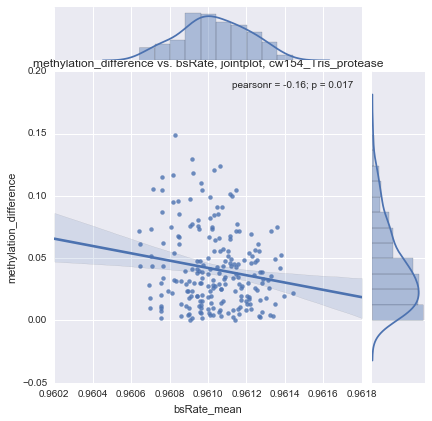

In [23]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs2, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, cw154_Tris_protease")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


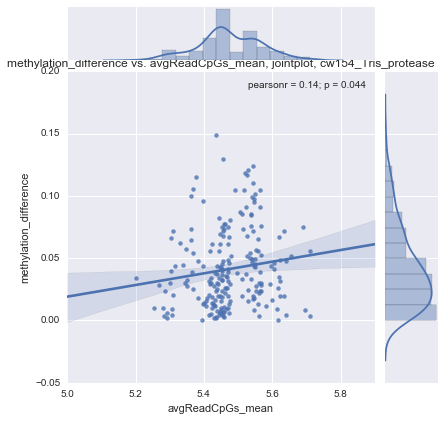

In [24]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs2, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, cw154_Tris_protease")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


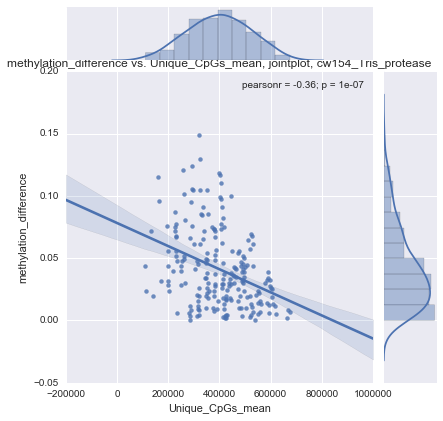

In [25]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs2, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, cw154_Tris_protease")

In [26]:
cw154 = merged[merged["protocol"] == 'cw154_Tris_protease_GR']
cw154 = cw154.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
cw154 = cw154.reset_index(drop=True)
cw154A = cw154.set_index("filename")
from itertools import combinations
cc = list(combinations(cw154.filename,2))
out = pd.DataFrame([cw154A.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(cw154.methylation, cw154.methylation)), cw154.filename, cw154.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs2a = pd.merge(out, methylation_differences, how='inner')
pairs2a = pairs2a.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs2a.methylation_difference # dependent variable
X = pairs2a.drop(['methylation', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for CLL 'RRBS_cw154_Tris_protease_GR', predict \delta methylation")
est.summary()

Regression results for CLL 'RRBS_cw154_Tris_protease_GR', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.136
Model:                                OLS   Adj. R-squared:                  0.123
Method:                     Least Squares   F-statistic:                     10.77
Date:                    Thu, 07 Jul 2016   Prob (F-statistic):           1.33e-06
Time:                            17:31:36   Log-Likelihood:                 498.91
No. Observations:                     210   AIC:                            -989.8
Df Residuals:                         206   BIC:                            -976.4
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const              -37.9900     10.478     -3.626      0.000       -58.648   -17.332
avgReadCpGs_mean     0.0108      0.017      0.640      0.523        -0.022     0.044
Unique_CpGs_mean -4.735e-08   1.19e-08     -3.967      0.000     -7.09e-08 -2.38e-08
bsRate_mean         39.5340     10.955      3.609      0.000        17.936    61.132
==============================================================================
Omnibus:                       10.651   Durbin-Watson:                   2.334
Prob(Omnibus):                  0.005   Jarque-Bera (JB):                4.876
Skew:                          -0.087   Prob(JB):                       0.0873
Kurtosis:                       2.274   Cond. No.                     5.05e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.05e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


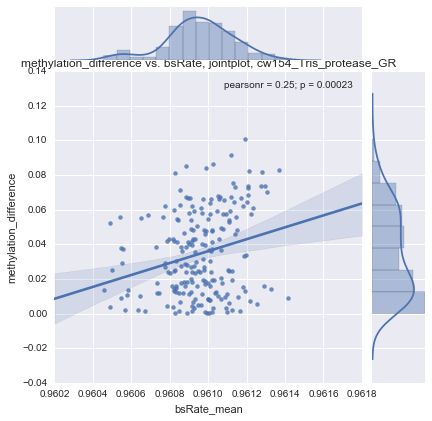

In [27]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs2a, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, cw154_Tris_protease_GR")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


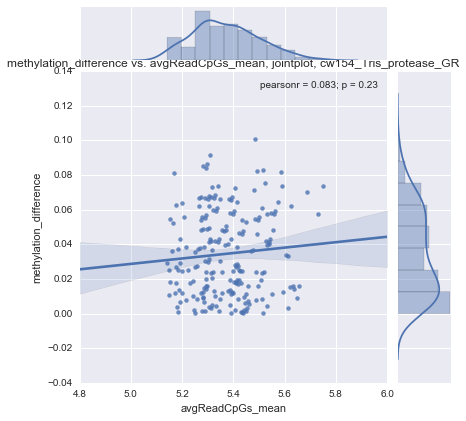

In [28]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs2a, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, cw154_Tris_protease_GR")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


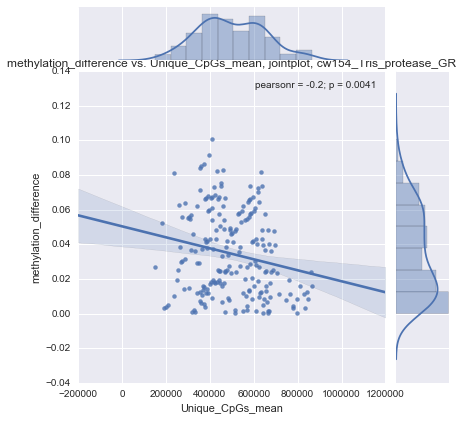

In [29]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs2a, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, cw154_Tris_protease_GR")

In [30]:
# cw154_CutSmart_proteinase_K
cw154 = merged[merged["protocol"] == 'cw154_CutSmart_proteinase_K']
cw154 = cw154.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
cw154 = cw154.reset_index(drop=True)
cw154A = cw154.set_index("filename")
from itertools import combinations
cc = list(combinations(cw154.filename,2))
out = pd.DataFrame([cw154A.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(cw154.methylation, cw154.methylation)), cw154.filename, cw154.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs2b = pd.merge(out, methylation_differences, how='inner')
pairs2b = pairs2b.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs2b.methylation_difference # dependent variable
X = pairs2b.drop(['methylation', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for CLL 'cw154_CutSmart_proteinase_K', predict \delta methylation")
est.summary()

Regression results for CLL 'cw154_CutSmart_proteinase_K', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.125
Model:                                OLS   Adj. R-squared:                  0.111
Method:                     Least Squares   F-statistic:                     8.883
Date:                    Thu, 07 Jul 2016   Prob (F-statistic):           1.57e-05
Time:                            17:31:39   Log-Likelihood:                 513.56
No. Observations:                     190   AIC:                            -1019.
Df Residuals:                         186   BIC:                            -1006.
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const              -36.8371     10.196     -3.613      0.000       -56.952   -16.723
avgReadCpGs_mean     0.0476      0.027      1.793      0.075        -0.005     0.100
Unique_CpGs_mean -6.113e-08   1.24e-08     -4.919      0.000     -8.56e-08 -3.66e-08
bsRate_mean         38.0089     10.600      3.586      0.000        17.098    58.920
==============================================================================
Omnibus:                        6.154   Durbin-Watson:                   1.681
Prob(Omnibus):                  0.046   Jarque-Bera (JB):                4.084
Skew:                           0.201   Prob(JB):                        0.130
Kurtosis:                       2.405   Cond. No.                     8.35e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.35e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


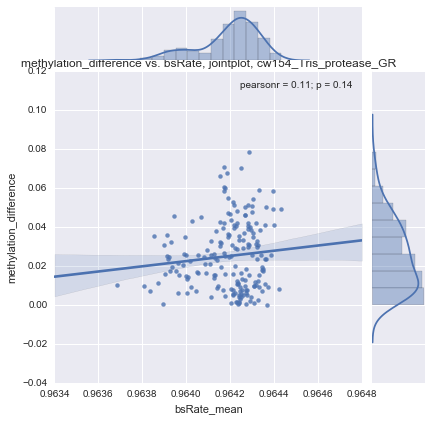

In [31]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs2b, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, cw154_Tris_protease_GR")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


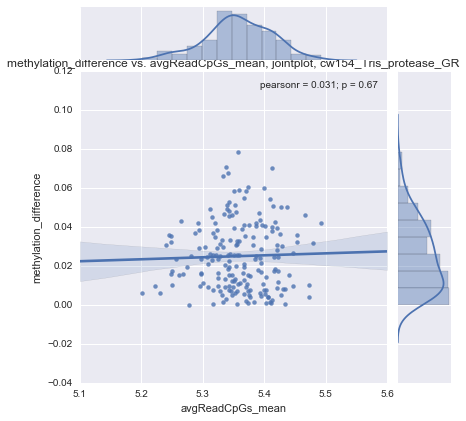

In [32]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs2b, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, cw154_Tris_protease_GR")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


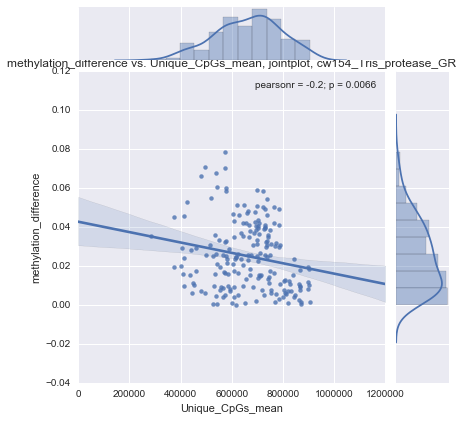

In [33]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs2b, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, cw154_Tris_protease_GR")

In [34]:
pcell = merged[merged["protocol"] == 'NormalBCD19pCD27pcell1_22_']
pcell = pcell.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
pcell = pcell.reset_index(drop=True)
pcellA = pcell.set_index("filename")
from itertools import combinations
cc = list(combinations(pcell.filename,2))
out = pd.DataFrame([pcellA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(pcell.methylation, pcell.methylation)), pcell.filename, pcell.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs3 = pd.merge(out, methylation_differences, how='inner')
pairs3 = pairs3.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs3.methylation_difference # dependent variable
X = pairs3.drop(['methylation', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for Normal B 'NormalBCD19pCD27pcell1_22', predict \delta methylation")
est.summary()

Regression results for Normal B 'NormalBCD19pCD27pcell1_22', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.205
Model:                                OLS   Adj. R-squared:                  0.189
Method:                     Least Squares   F-statistic:                     12.80
Date:                    Thu, 07 Jul 2016   Prob (F-statistic):           1.73e-07
Time:                            17:31:43   Log-Likelihood:                 335.09
No. Observations:                     153   AIC:                            -662.2
Df Residuals:                         149   BIC:                            -650.1
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const              -66.4226     38.689     -1.717      0.088      -142.873    10.028
avgReadCpGs_mean     0.1875      0.037      5.119      0.000         0.115     0.260
Unique_CpGs_mean -1.921e-08    2.9e-08     -0.663      0.509     -7.65e-08  3.81e-08
bsRate_mean         65.6441     38.782      1.693      0.093       -10.990   142.278
==============================================================================
Omnibus:                       12.638   Durbin-Watson:                   1.173
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.287
Skew:                           0.658   Prob(JB):                      0.00130
Kurtosis:                       3.594   Cond. No.                     9.28e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.28e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


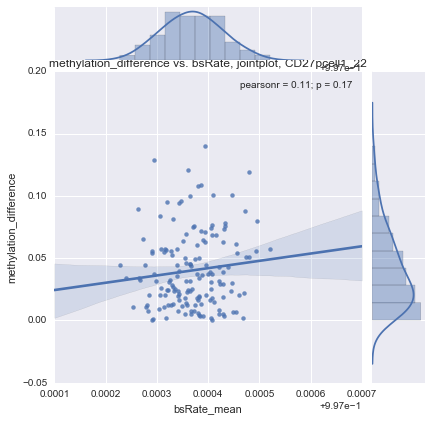

In [35]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs3, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, CD27pcell1_22")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


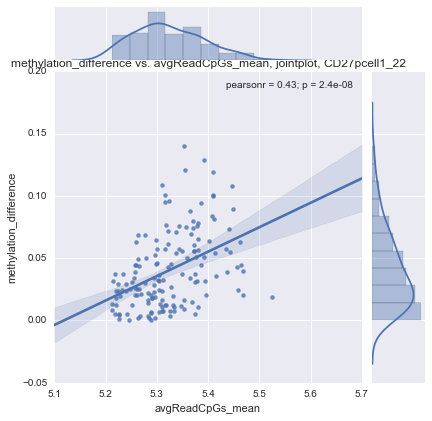

In [36]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs3, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, CD27pcell1_22")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


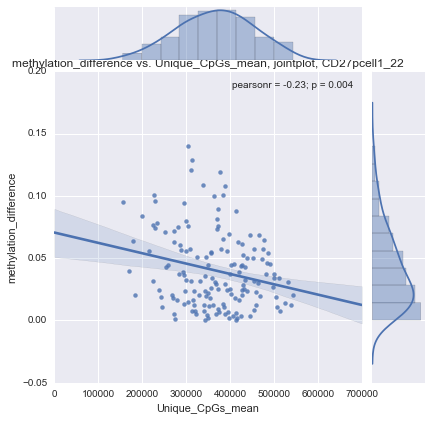

In [37]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs3, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, CD27pcell1_22")

In [38]:
pcell = merged[merged["protocol"] == 'NormalBCD19pCD27pcell23_44']
pcell = pcell.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
pcell = pcell.reset_index(drop=True)
pcellA = pcell.set_index("filename")
from itertools import combinations
cc = list(combinations(pcell.filename,2))
out = pd.DataFrame([pcellA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(pcell.methylation, pcell.methylation)), pcell.filename, pcell.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs3a = pd.merge(out, methylation_differences, how='inner')
pairs3a = pairs3a.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs3a.methylation_difference # dependent variable
X = pairs3a.drop(['methylation', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for Normal B 'NormalBCD19pCD27pcell22_34', predict \delta methylation")
est.summary()

Regression results for Normal B 'NormalBCD19pCD27pcell22_34', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.100
Model:                                OLS   Adj. R-squared:                  0.088
Method:                     Least Squares   F-statistic:                     8.375
Date:                    Thu, 07 Jul 2016   Prob (F-statistic):           2.64e-05
Time:                            17:31:46   Log-Likelihood:                 530.10
No. Observations:                     231   AIC:                            -1052.
Df Residuals:                         227   BIC:                            -1038.
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const              -36.9500     40.824     -0.905      0.366      -117.392    43.492
avgReadCpGs_mean     0.0896      0.021      4.300      0.000         0.049     0.131
Unique_CpGs_mean  2.035e-08   2.48e-08      0.821      0.413     -2.85e-08  6.92e-08
bsRate_mean         36.5874     40.900      0.895      0.372       -44.005   117.179
==============================================================================
Omnibus:                       11.986   Durbin-Watson:                   1.424
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               12.730
Skew:                           0.574   Prob(JB):                      0.00172
Kurtosis:                       3.050   Cond. No.                     1.28e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.28e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


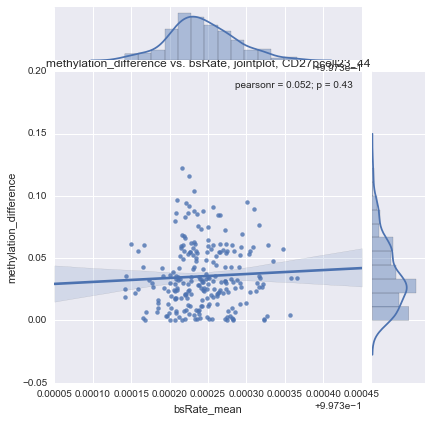

In [39]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs3a, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, CD27pcell23_44")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


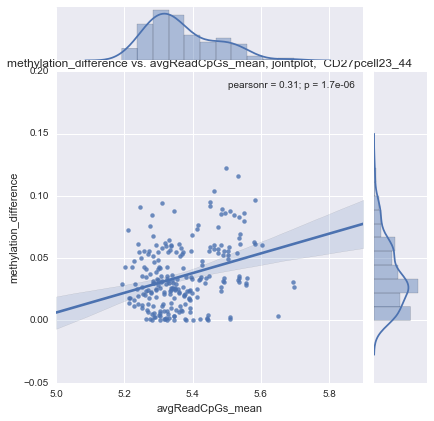

In [40]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs3a, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot,  CD27pcell23_44")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


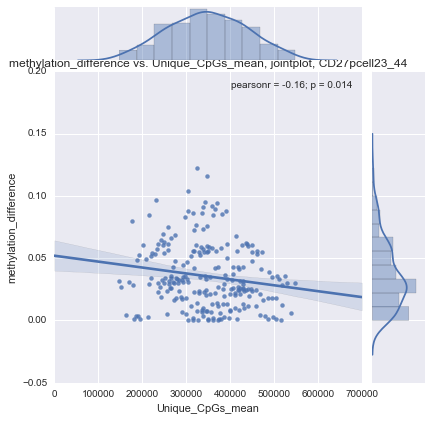

In [41]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs3a, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, CD27pcell23_44")

In [42]:
pcell = merged[merged["protocol"] == 'NormalBCD19pCD27pcell45_66']
pcell = pcell.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
pcell = pcell.reset_index(drop=True)
pcellA = pcell.set_index("filename")
from itertools import combinations
cc = list(combinations(pcell.filename,2))
out = pd.DataFrame([pcellA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(pcell.methylation, pcell.methylation)), pcell.filename, pcell.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs3b = pd.merge(out, methylation_differences, how='inner')
pairs3b = pairs3b.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs3b.methylation_difference # dependent variable
X = pairs3b.drop(['methylation', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for Normal B 'NormalBCD19pCD27pcell45_66', predict \delta methylation")
est.summary()

Regression results for Normal B 'NormalBCD19pCD27pcell45_66', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.431
Model:                                OLS   Adj. R-squared:                  0.377
Method:                     Least Squares   F-statistic:                     8.072
Date:                    Thu, 07 Jul 2016   Prob (F-statistic):           0.000382
Time:                            17:31:49   Log-Likelihood:                 80.641
No. Observations:                      36   AIC:                            -153.3
Df Residuals:                          32   BIC:                            -146.9
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const              479.1911    194.884      2.459      0.020        82.226   876.157
avgReadCpGs_mean     0.0575      0.067      0.862      0.395        -0.078     0.193
Unique_CpGs_mean -3.026e-08   2.76e-08     -1.097      0.281     -8.65e-08   2.6e-08
bsRate_mean       -480.6305    195.095     -2.464      0.019      -878.027   -83.234
==============================================================================
Omnibus:                        5.527   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.063   Jarque-Bera (JB):                4.062
Skew:                          -0.747   Prob(JB):                        0.131
Kurtosis:                       3.691   Cond. No.                     3.46e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.46e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


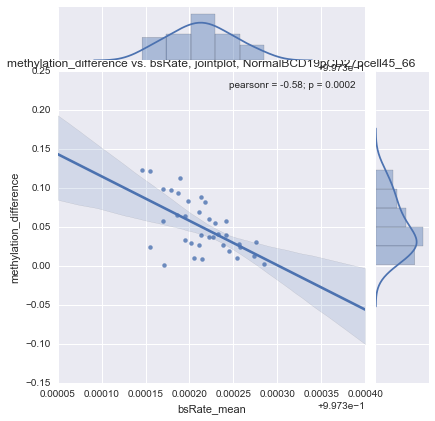

In [43]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs3b, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, NormalBCD19pCD27pcell45_66")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


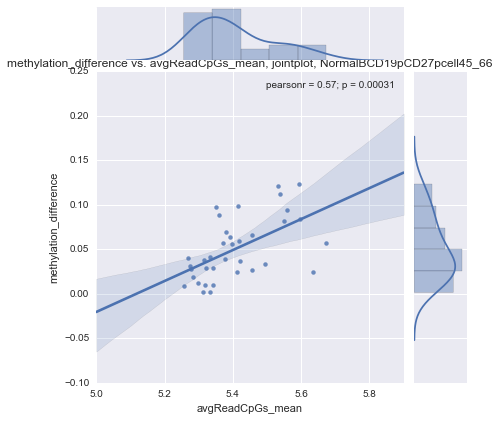

In [44]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs3b, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, NormalBCD19pCD27pcell45_66")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


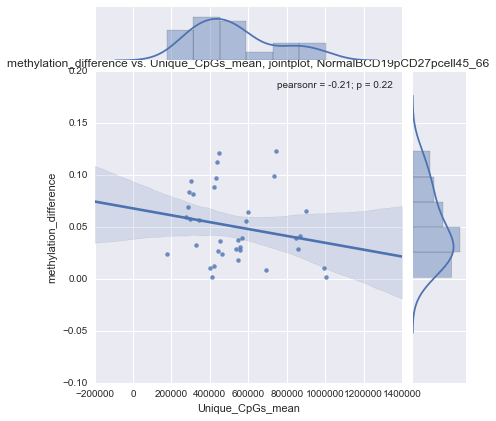

In [45]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs3b, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, NormalBCD19pCD27pcell45_66")

In [46]:
pcell = merged[merged["protocol"] == 'NormalBCD19pCD27pcell67_88']
pcell = pcell.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
pcell = pcell.reset_index(drop=True)
pcellA = pcell.set_index("filename")
from itertools import combinations
cc = list(combinations(pcell.filename,2))
out = pd.DataFrame([pcellA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(pcell.methylation, pcell.methylation)), pcell.filename, pcell.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs3c = pd.merge(out, methylation_differences, how='inner')
pairs3c = pairs3c.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs3c.methylation_difference # dependent variable
X = pairs3c.drop(['methylation', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for Normal B 'NormalBCD19pCD27pcell67_88', predict \delta methylation")
est.summary()

Regression results for Normal B 'NormalBCD19pCD27pcell67_88', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.078
Model:                                OLS   Adj. R-squared:                  0.065
Method:                     Least Squares   F-statistic:                     5.840
Date:                    Thu, 07 Jul 2016   Prob (F-statistic):           0.000757
Time:                            17:31:53   Log-Likelihood:                 519.09
No. Observations:                     210   AIC:                            -1030.
Df Residuals:                         206   BIC:                            -1017.
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const               49.9887     30.777      1.624      0.106       -10.690   110.668
avgReadCpGs_mean    -0.0765      0.032     -2.360      0.019        -0.140    -0.013
Unique_CpGs_mean -5.825e-08   1.81e-08     -3.223      0.001     -9.39e-08 -2.26e-08
bsRate_mean        -49.6796     30.797     -1.613      0.108      -110.396    11.037
==============================================================================
Omnibus:                       23.302   Durbin-Watson:                   1.469
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.453
Skew:                           0.847   Prob(JB):                     1.09e-06
Kurtosis:                       3.515   Cond. No.                     1.06e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


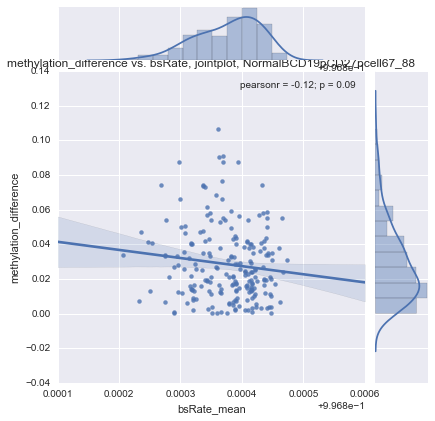

In [47]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs3c, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, NormalBCD19pCD27pcell67_88")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


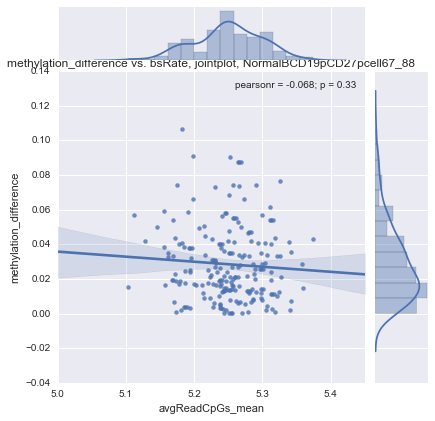

In [48]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs3c, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, NormalBCD19pCD27pcell67_88")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


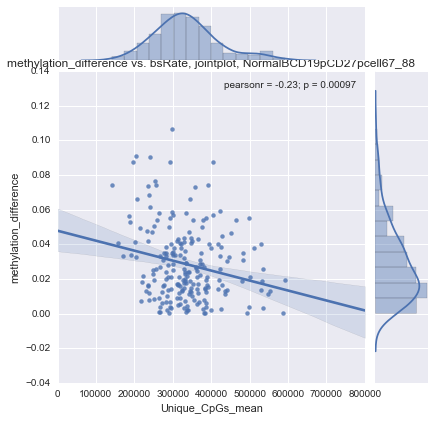

In [49]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs3c, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, NormalBCD19pCD27pcell67_88")

In [50]:
mcell = merged[merged["protocol"] == 'NormalBCD19pCD27mcell1_22_']
mcell = mcell.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
mcell = mcell.reset_index(drop=True)
mcellA = mcell.set_index("filename")
from itertools import combinations
cc = list(combinations(mcell.filename,2))
out = pd.DataFrame([mcellA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(mcell.methylation, mcell.methylation)), mcell.filename, mcell.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs4 = pd.merge(out, methylation_differences, how='inner')
pairs4 = pairs4.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs4.methylation_difference # dependent variable
X = pairs4.drop(['methylation', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'NormalBCD19pCD27mcell1_22', predict \delta methylation")
est.summary()

Regression results for 'NormalBCD19pCD27mcell1_22', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.354
Model:                                OLS   Adj. R-squared:                  0.341
Method:                     Least Squares   F-statistic:                     27.26
Date:                    Thu, 07 Jul 2016   Prob (F-statistic):           4.13e-14
Time:                            17:31:56   Log-Likelihood:                 327.21
No. Observations:                     153   AIC:                            -646.4
Df Residuals:                         149   BIC:                            -634.3
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const             -148.4848     68.682     -2.162      0.032      -284.202   -12.768
avgReadCpGs_mean     0.2921      0.042      7.026      0.000         0.210     0.374
Unique_CpGs_mean  1.841e-07   3.88e-08      4.743      0.000      1.07e-07  2.61e-07
bsRate_mean        147.2643     68.940      2.136      0.034        11.038   283.491
==============================================================================
Omnibus:                        4.360   Durbin-Watson:                   1.242
Prob(Omnibus):                  0.113   Jarque-Bera (JB):                4.418
Skew:                           0.391   Prob(JB):                        0.110
Kurtosis:                       2.712   Cond. No.                     1.65e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.65e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


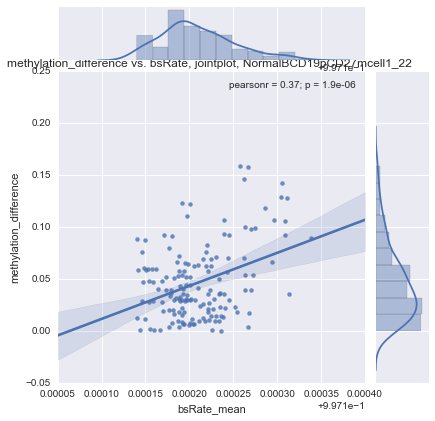

In [51]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs4, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, NormalBCD19pCD27mcell1_22 ")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


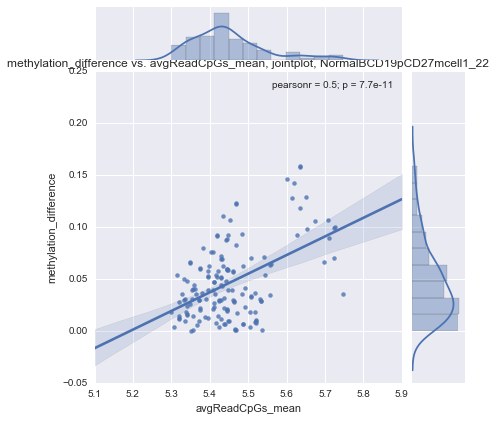

In [52]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs4, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, NormalBCD19pCD27mcell1_22")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


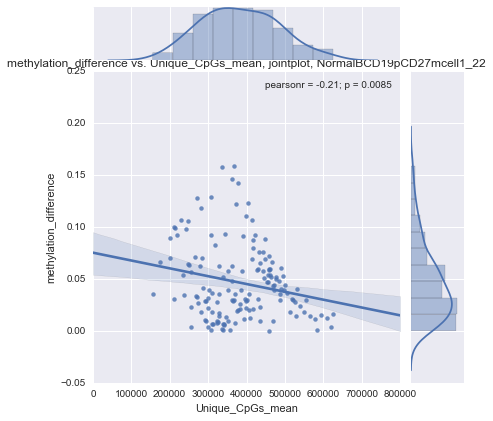

In [53]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs4, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, NormalBCD19pCD27mcell1_22")

In [54]:
mcell = merged[merged["protocol"] == 'NormalBCD19pCD27mcell23_44']
mcell = mcell.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
mcell = mcell.reset_index(drop=True)
mcellA = mcell.set_index("filename")
from itertools import combinations
cc = list(combinations(mcell.filename,2))
out = pd.DataFrame([mcellA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(mcell.methylation, mcell.methylation)), mcell.filename, mcell.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs4a = pd.merge(out, methylation_differences, how='inner')
pairs4a = pairs4a.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs4a.methylation_difference # dependent variable
X = pairs4a.drop(['methylation', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'NormalBCD19pCD27mcell23_44', predict \delta methylation")
est.summary()

Regression results for 'NormalBCD19pCD27mcell23_44', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.060
Model:                                OLS   Adj. R-squared:                  0.044
Method:                     Least Squares   F-statistic:                     3.583
Date:                    Thu, 07 Jul 2016   Prob (F-statistic):             0.0151
Time:                            17:32:00   Log-Likelihood:                 405.33
No. Observations:                     171   AIC:                            -802.7
Df Residuals:                         167   BIC:                            -790.1
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const             -136.3314     67.169     -2.030      0.044      -268.941    -3.721
avgReadCpGs_mean    -0.1269      0.048     -2.640      0.009        -0.222    -0.032
Unique_CpGs_mean -5.157e-08   3.17e-08     -1.627      0.106     -1.14e-07   1.1e-08
bsRate_mean        137.3941     67.340      2.040      0.043         4.447   270.341
==============================================================================
Omnibus:                       11.910   Durbin-Watson:                   1.292
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               12.792
Skew:                           0.669   Prob(JB):                      0.00167
Kurtosis:                       3.075   Cond. No.                     1.91e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.91e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


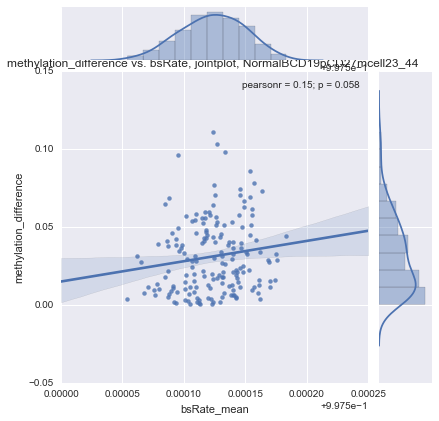

In [55]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs4a, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, NormalBCD19pCD27mcell23_44 ")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


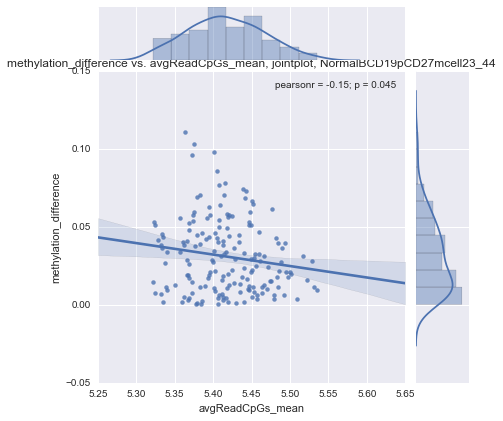

In [56]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs4a, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, NormalBCD19pCD27mcell23_44")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


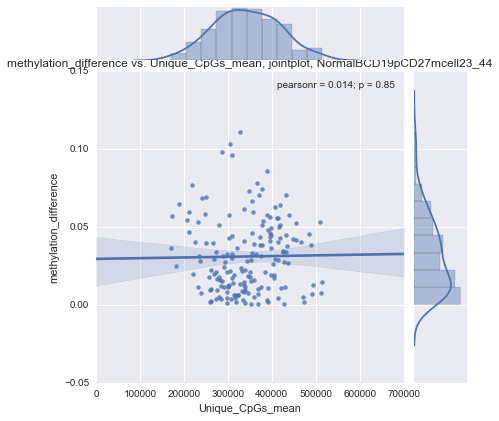

In [57]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs4a, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, NormalBCD19pCD27mcell23_44")

In [58]:
mcell = merged[merged["protocol"] == 'NormalBCD19pCD27mcell45_66']
mcell = mcell.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
mcell = mcell.reset_index(drop=True)
mcellA = mcell.set_index("filename")
from itertools import combinations
cc = list(combinations(mcell.filename,2))
out = pd.DataFrame([mcellA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(mcell.methylation, mcell.methylation)), mcell.filename, mcell.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs4b = pd.merge(out, methylation_differences, how='inner')
pairs4b = pairs4b.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs4b.methylation_difference # dependent variable
X = pairs4b.drop(['methylation', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'NormalBCD19pCD27mcell23_44', predict \delta methylation")
est.summary()

Regression results for 'NormalBCD19pCD27mcell23_44', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.412
Model:                                OLS   Adj. R-squared:                  0.399
Method:                     Least Squares   F-statistic:                     30.83
Date:                    Thu, 07 Jul 2016   Prob (F-statistic):           3.61e-15
Time:                            17:32:03   Log-Likelihood:                 297.64
No. Observations:                     136   AIC:                            -587.3
Df Residuals:                         132   BIC:                            -575.6
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const              160.0124     70.843      2.259      0.026        19.877   300.148
avgReadCpGs_mean     0.3879      0.042      9.168      0.000         0.304     0.472
Unique_CpGs_mean  2.518e-07   4.53e-08      5.557      0.000      1.62e-07  3.41e-07
bsRate_mean       -162.5549     71.022     -2.289      0.024      -303.044   -22.066
==============================================================================
Omnibus:                        2.422   Durbin-Watson:                   1.241
Prob(Omnibus):                  0.298   Jarque-Bera (JB):                2.426
Skew:                           0.279   Prob(JB):                        0.297
Kurtosis:                       2.657   Cond. No.                     1.55e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.55e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


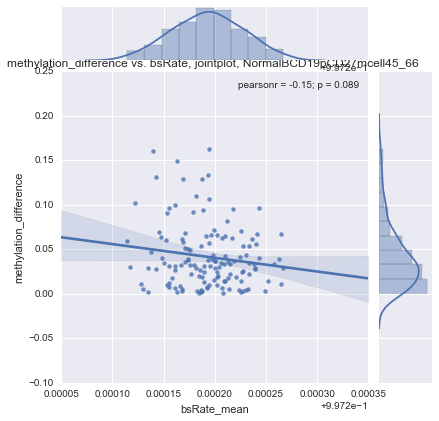

In [59]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs4b, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, NormalBCD19pCD27mcell45_66 ")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


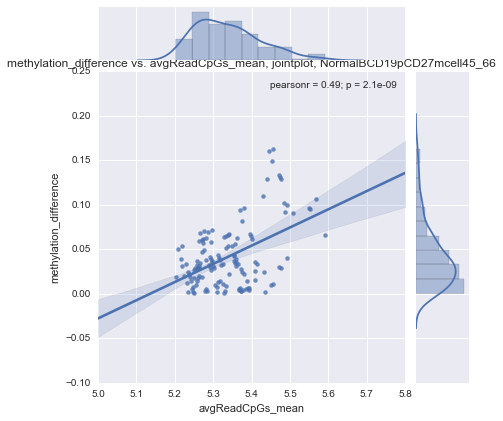

In [60]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs4b, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, NormalBCD19pCD27mcell45_66")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


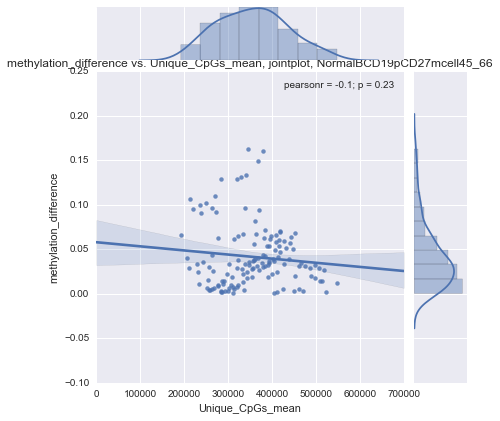

In [61]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs4b, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, NormalBCD19pCD27mcell45_66")

In [62]:
mcell = merged[merged["protocol"] == 'NormalBCD19pCD27mcell67_88']
mcell = mcell.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
mcell = mcell.reset_index(drop=True)
mcellA = mcell.set_index("filename")
from itertools import combinations
cc = list(combinations(mcell.filename,2))
out = pd.DataFrame([mcellA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(mcell.methylation, mcell.methylation)), mcell.filename, mcell.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs4c = pd.merge(out, methylation_differences, how='inner')
pairs4c = pairs4c.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs4c.methylation_difference # dependent variable
X = pairs4c.drop(['methylation', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'NormalBCD19pCD27mcell23_44', predict \delta methylation")
est.summary()

Regression results for 'NormalBCD19pCD27mcell23_44', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.107
Model:                                OLS   Adj. R-squared:                  0.094
Method:                     Least Squares   F-statistic:                     8.241
Date:                    Thu, 07 Jul 2016   Prob (F-statistic):           3.33e-05
Time:                            17:32:07   Log-Likelihood:                 451.39
No. Observations:                     210   AIC:                            -894.8
Df Residuals:                         206   BIC:                            -881.4
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const               18.5498     66.330      0.280      0.780      -112.223   149.323
avgReadCpGs_mean     0.1364      0.031      4.424      0.000         0.076     0.197
Unique_CpGs_mean  4.916e-08   2.94e-08      1.674      0.096     -8.75e-09  1.07e-07
bsRate_mean        -19.3246     66.508     -0.291      0.772      -150.448   111.798
==============================================================================
Omnibus:                        8.210   Durbin-Watson:                   2.190
Prob(Omnibus):                  0.016   Jarque-Bera (JB):                8.613
Skew:                           0.489   Prob(JB):                       0.0135
Kurtosis:                       2.830   Cond. No.                     2.04e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.04e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


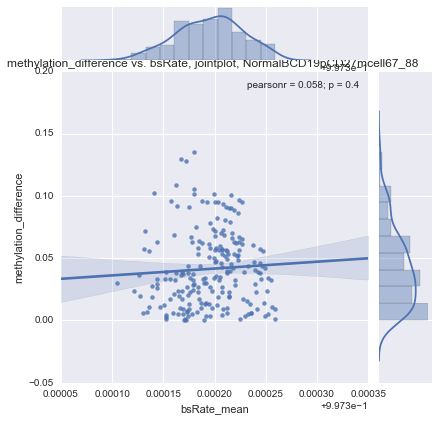

In [63]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs4c, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, NormalBCD19pCD27mcell67_88 ")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


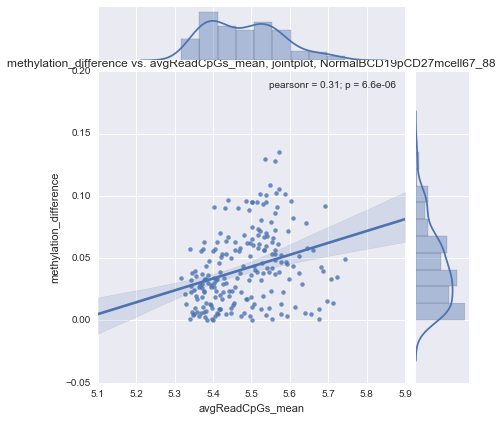

In [64]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs4c, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, NormalBCD19pCD27mcell67_88")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


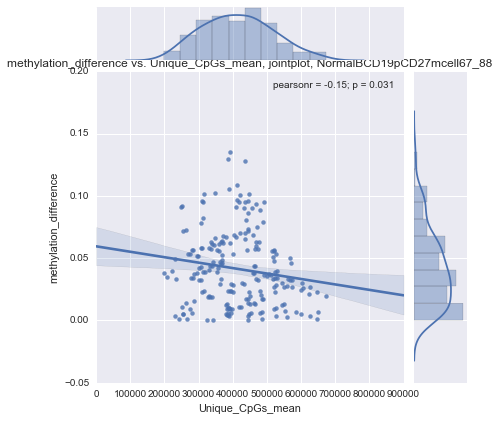

In [65]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs4c, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, NormalBCD19pCD27mcell67_88")

In [66]:
normb = merged[merged["protocol"] == 'normal_B_cell_A1_24']
normb = normb.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
normb = normb.reset_index(drop=True)
normbA = normb.set_index("filename")
from itertools import combinations
cc = list(combinations(normb.filename,2))
out = pd.DataFrame([normbA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(normb.methylation, normb.methylation)), normb.filename, normb.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs5 = pd.merge(out, methylation_differences, how='inner')
pairs5 = pairs5.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs5.methylation_difference # dependent variable
X = pairs5.drop(['methylation', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'normal_B_cell_A1_24', predict \delta methylation")
est.summary()

Regression results for 'normal_B_cell_A1_24', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.028
Model:                                OLS   Adj. R-squared:                  0.013
Method:                     Least Squares   F-statistic:                     1.810
Date:                    Thu, 07 Jul 2016   Prob (F-statistic):              0.147
Time:                            17:32:10   Log-Likelihood:                 497.40
No. Observations:                     190   AIC:                            -986.8
Df Residuals:                         186   BIC:                            -973.8
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const                9.8111      4.753      2.064      0.040         0.435    19.187
avgReadCpGs_mean     0.0274      0.025      1.087      0.279        -0.022     0.077
Unique_CpGs_mean -2.299e-08   3.69e-08     -0.623      0.534     -9.58e-08  4.98e-08
bsRate_mean        -10.3555      4.971     -2.083      0.039       -20.162    -0.549
==============================================================================
Omnibus:                       24.005   Durbin-Watson:                   1.209
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.005
Skew:                           0.930   Prob(JB):                     5.03e-07
Kurtosis:                       3.448   Cond. No.                     1.17e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.17e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


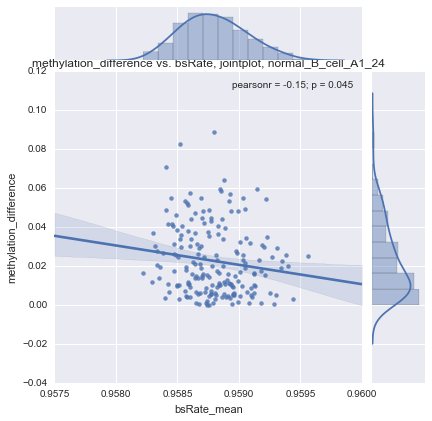

In [67]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs5, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, normal_B_cell_A1_24")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


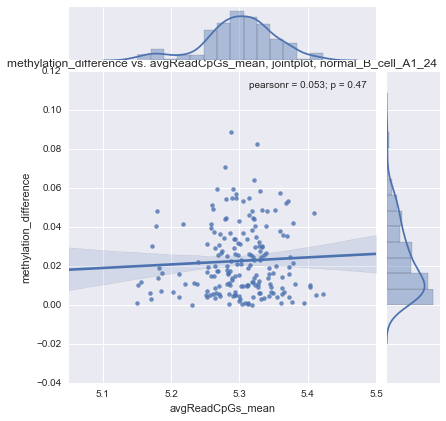

In [68]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs5, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, normal_B_cell_A1_24")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


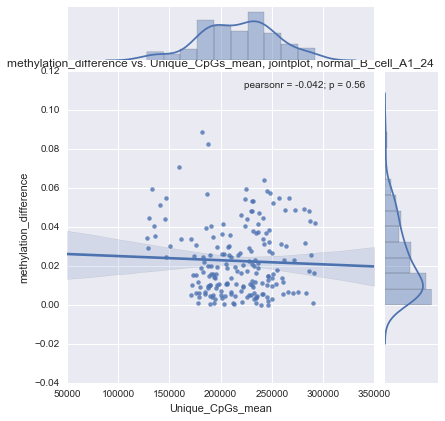

In [69]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs5, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, normal_B_cell_A1_24")

In [70]:
normb = merged[merged["protocol"] == 'normal_B_cell_B1_24']
normb = normb.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
normb = normb.reset_index(drop=True)
normbA = normb.set_index("filename")
from itertools import combinations
cc = list(combinations(normb.filename,2))
out = pd.DataFrame([normbA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(normb.methylation, normb.methylation)), normb.filename, normb.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs5a = pd.merge(out, methylation_differences, how='inner')
pairs5a = pairs5a.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs5a.methylation_difference # dependent variable
X = pairs5a.drop(['methylation', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'normal_B_cell_B1_24', predict \delta methylation")
est.summary()

Regression results for 'normal_B_cell_B1_24', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.009
Model:                                OLS   Adj. R-squared:                 -0.007
Method:                     Least Squares   F-statistic:                    0.5330
Date:                    Thu, 07 Jul 2016   Prob (F-statistic):              0.660
Time:                            17:32:13   Log-Likelihood:                 419.65
No. Observations:                     190   AIC:                            -831.3
Df Residuals:                         186   BIC:                            -818.3
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const                3.8957     17.049      0.228      0.820       -29.739    37.530
avgReadCpGs_mean     0.0294      0.032      0.930      0.353        -0.033     0.092
Unique_CpGs_mean  1.614e-08   1.78e-08      0.904      0.367     -1.91e-08  5.14e-08
bsRate_mean         -4.1846     17.853     -0.234      0.815       -39.404    31.035
==============================================================================
Omnibus:                       11.980   Durbin-Watson:                   1.751
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               12.746
Skew:                           0.608   Prob(JB):                      0.00171
Kurtosis:                       2.639   Cond. No.                     5.83e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.83e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


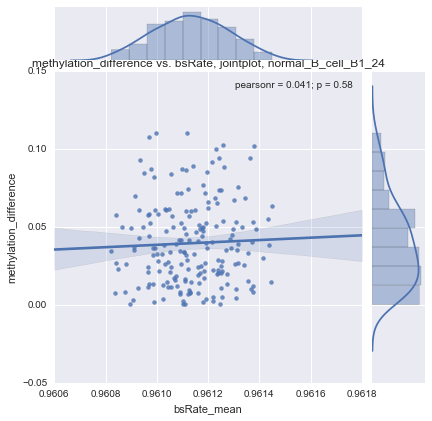

In [71]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs5a, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, normal_B_cell_B1_24")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


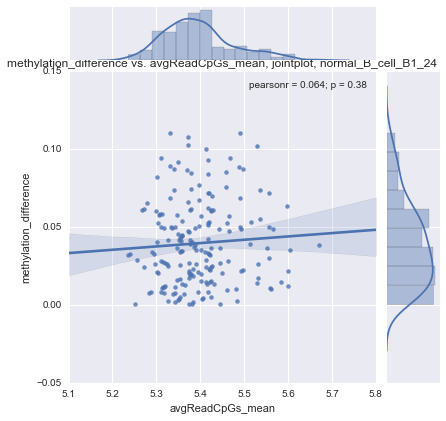

In [72]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs5a, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, normal_B_cell_B1_24")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


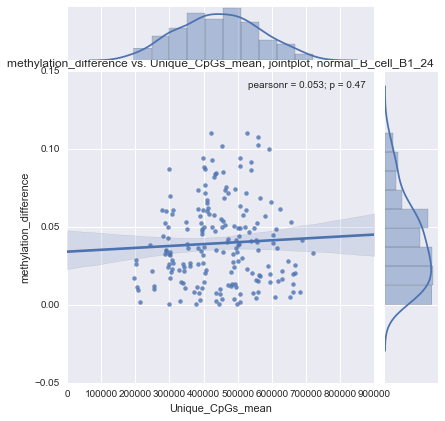

In [73]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs5a, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, normal_B_cell_B1_24")

In [74]:
normb = merged[merged["protocol"] == 'normal_B_cell_C1_24']
normb = normb.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
normb = normb.reset_index(drop=True)
normbA = normb.set_index("filename")
from itertools import combinations
cc = list(combinations(normb.filename,2))
out = pd.DataFrame([normbA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(normb.methylation, normb.methylation)), normb.filename, normb.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs5b = pd.merge(out, methylation_differences, how='inner')
pairs5b = pairs5b.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs5b.methylation_difference # dependent variable
X = pairs5b.drop(['methylation', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'normal_B_cell_C1_24', predict \delta methylation")
est.summary()

Regression results for 'normal_B_cell_C1_24', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.049
Model:                                OLS   Adj. R-squared:                  0.037
Method:                     Least Squares   F-statistic:                     3.907
Date:                    Thu, 07 Jul 2016   Prob (F-statistic):            0.00951
Time:                            17:32:17   Log-Likelihood:                 511.55
No. Observations:                     231   AIC:                            -1015.
Df Residuals:                         227   BIC:                            -1001.
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const              -21.2978     14.492     -1.470      0.143       -49.854     7.258
avgReadCpGs_mean    -0.1188      0.040     -3.000      0.003        -0.197    -0.041
Unique_CpGs_mean -9.178e-09    8.7e-09     -1.054      0.293     -2.63e-08  7.97e-09
bsRate_mean         22.8534     15.189      1.505      0.134        -7.077    52.784
==============================================================================
Omnibus:                       14.453   Durbin-Watson:                   1.169
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.428
Skew:                           0.606   Prob(JB):                     0.000446
Kurtosis:                       2.633   Cond. No.                     9.25e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.25e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


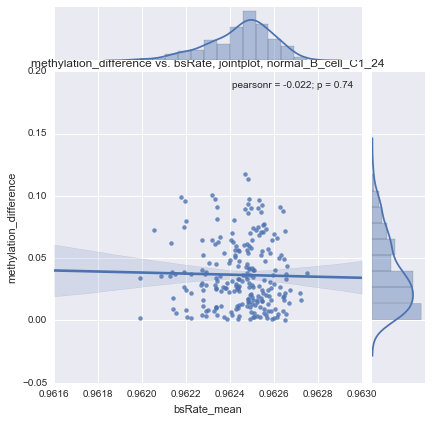

In [75]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs5b, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, normal_B_cell_C1_24")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


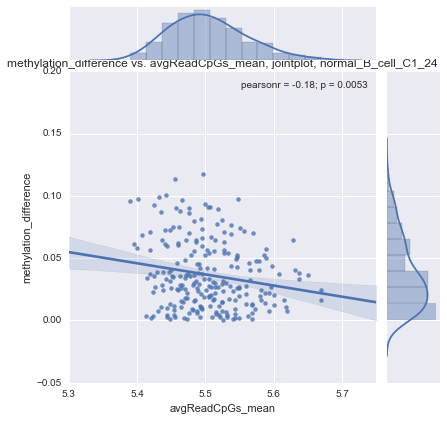

In [76]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs5b, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, normal_B_cell_C1_24")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


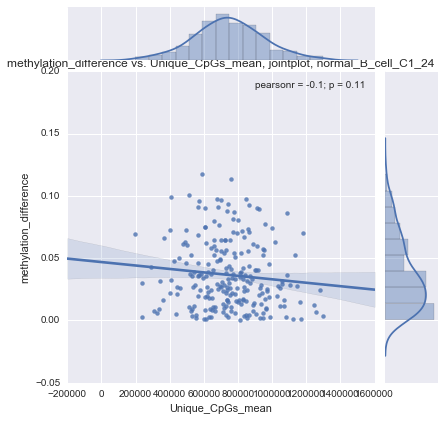

In [77]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs5b, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, normal_B_cell_C1_24")

In [78]:
normb = merged[merged["protocol"] == 'normal_B_cell_D1_24']
normb = normb.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
normb = normb.reset_index(drop=True)
normbA = normb.set_index("filename")
from itertools import combinations
cc = list(combinations(normb.filename,2))
out = pd.DataFrame([normbA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(normb.methylation, normb.methylation)), normb.filename, normb.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs5c = pd.merge(out, methylation_differences, how='inner')
pairs5c = pairs5c.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs5c.methylation_difference # dependent variable
X = pairs5c.drop(['methylation', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'normal_B_cell_D1_24', predict \delta methylation")
est.summary()

Regression results for 'normal_B_cell_D1_24', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.180
Model:                                OLS   Adj. R-squared:                  0.103
Method:                     Least Squares   F-statistic:                     2.337
Date:                    Thu, 07 Jul 2016   Prob (F-statistic):             0.0922
Time:                            17:32:20   Log-Likelihood:                 84.258
No. Observations:                      36   AIC:                            -160.5
Df Residuals:                          32   BIC:                            -154.2
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const               12.8641     28.172      0.457      0.651       -44.521    70.250
avgReadCpGs_mean    -0.1455      0.061     -2.399      0.022        -0.269    -0.022
Unique_CpGs_mean  8.849e-09   2.83e-08      0.313      0.756     -4.87e-08  6.64e-08
bsRate_mean        -12.5137     29.340     -0.427      0.673       -72.277    47.249
==============================================================================
Omnibus:                        0.899   Durbin-Watson:                   2.287
Prob(Omnibus):                  0.638   Jarque-Bera (JB):                0.803
Skew:                          -0.056   Prob(JB):                        0.669
Kurtosis:                       2.277   Cond. No.                     7.43e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.43e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


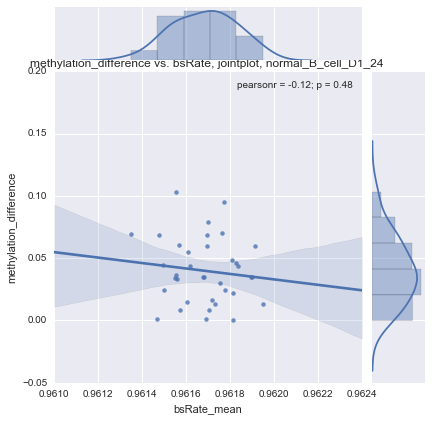

In [79]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs5c, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, normal_B_cell_D1_24 ")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


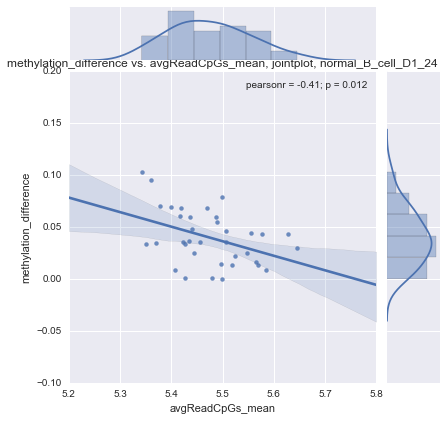

In [80]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs5c, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, normal_B_cell_D1_24")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


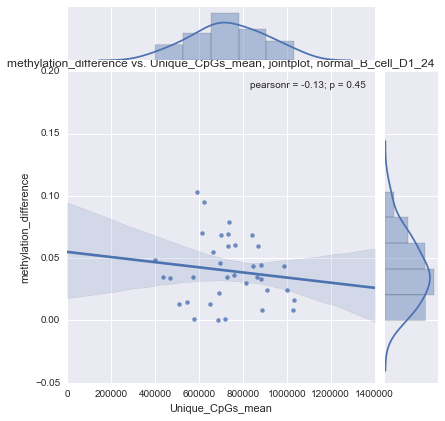

In [81]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs5c, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, normal_B_cell_D1_24")

In [82]:
normb = merged[merged["protocol"] == 'normal_B_cell_G1_22']
normb = normb.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
normb = normb.reset_index(drop=True)
normbA = normb.set_index("filename")
from itertools import combinations
cc = list(combinations(normb.filename,2))
out = pd.DataFrame([normbA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(normb.methylation, normb.methylation)), normb.filename, normb.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs5d = pd.merge(out, methylation_differences, how='inner')
pairs5d = pairs5d.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs5d.methylation_difference # dependent variable
X = pairs5d.drop(['methylation', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'normal_B_cell_G1_22', predict \delta methylation")
est.summary()

Regression results for 'normal_B_cell_G1_22', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.105
Model:                                OLS   Adj. R-squared:                  0.089
Method:                     Least Squares   F-statistic:                     6.528
Date:                    Thu, 07 Jul 2016   Prob (F-statistic):           0.000335
Time:                            17:32:23   Log-Likelihood:                 345.27
No. Observations:                     171   AIC:                            -682.5
Df Residuals:                         167   BIC:                            -670.0
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const               48.9907     15.172      3.229      0.001        19.036    78.945
avgReadCpGs_mean     0.2198      0.056      3.945      0.000         0.110     0.330
Unique_CpGs_mean  2.636e-08   2.34e-08      1.128      0.261     -1.98e-08  7.25e-08
bsRate_mean        -52.2150     15.976     -3.268      0.001       -83.756   -20.674
==============================================================================
Omnibus:                       12.550   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.726
Skew:                           0.694   Prob(JB):                      0.00105
Kurtosis:                       3.018   Cond. No.                     5.53e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.53e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


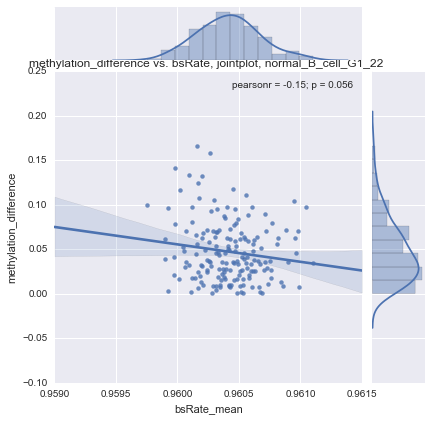

In [83]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs5d, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, normal_B_cell_G1_22 ")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


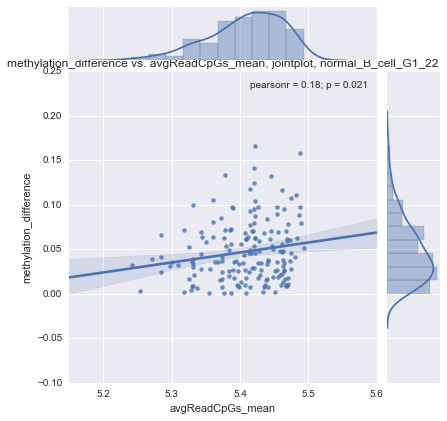

In [84]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs5d, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, normal_B_cell_G1_22")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


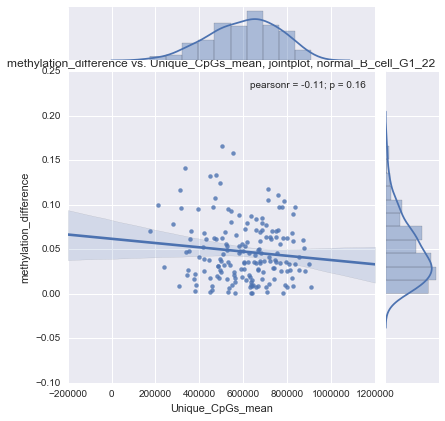

In [85]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs5d, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, normal_B_cell_G1_22")

In [86]:
normb = merged[merged["protocol"] == 'normal_B_cell_H1_22']
normb = normb.drop(["type", "bio", "protocol", "avgReadCpGs_median"], axis=1)
normb = normb.reset_index(drop=True)
normbA = normb.set_index("filename")
from itertools import combinations
cc = list(combinations(normb.filename,2))
out = pd.DataFrame([normbA.loc[c,:].mean() for c in cc], index=cc)
df_ex = pd.DataFrame(np.abs(np.subtract.outer(normb.methylation, normb.methylation)), normb.filename, normb.filename)
stacked = df_ex.stack()
methylation_differences = pd.DataFrame({'filename': stacked.index.to_series(), 'methylation_difference': stacked})[['filename', 'methylation_difference']].reset_index(drop=True)
out['filename'] = out.index
out = out.reset_index(drop=True)
pairs5e = pd.merge(out, methylation_differences, how='inner')
pairs5e = pairs5e.rename(columns = {'total_reads':'total_reads_mean', 'Unique_CpGs':'Unique_CpGs_mean', "bsRate":"bsRate_mean"})
y = pairs5e.methylation_difference # dependent variable
X = pairs5e.drop(['methylation', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results for 'normal_B_cell_H1_22', predict \delta methylation")
est.summary()

Regression results for 'normal_B_cell_H1_22', predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.069
Model:                                OLS   Adj. R-squared:                  0.045
Method:                     Least Squares   F-statistic:                     2.881
Date:                    Thu, 07 Jul 2016   Prob (F-statistic):             0.0389
Time:                            17:32:26   Log-Likelihood:                 259.56
No. Observations:                     120   AIC:                            -511.1
Df Residuals:                         116   BIC:                            -500.0
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const               20.5223     22.122      0.928      0.355       -23.293    64.338
avgReadCpGs_mean     0.1476      0.051      2.902      0.004         0.047     0.248
Unique_CpGs_mean  -4.42e-08   3.01e-08     -1.468      0.145     -1.04e-07  1.54e-08
bsRate_mean        -22.1098     23.090     -0.958      0.340       -67.843    23.624
==============================================================================
Omnibus:                        9.185   Durbin-Watson:                   1.890
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                9.729
Skew:                           0.697   Prob(JB):                      0.00771
Kurtosis:                       2.968   Cond. No.                     6.56e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.56e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


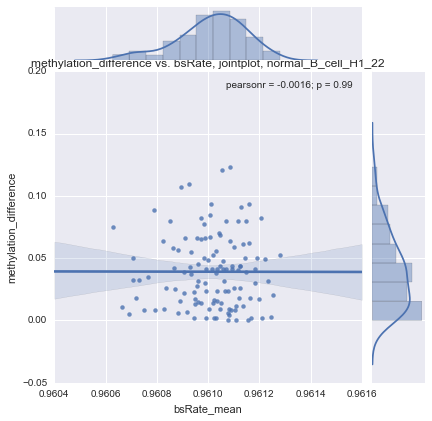

In [87]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=pairs5e, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, normal_B_cell_H1_22")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


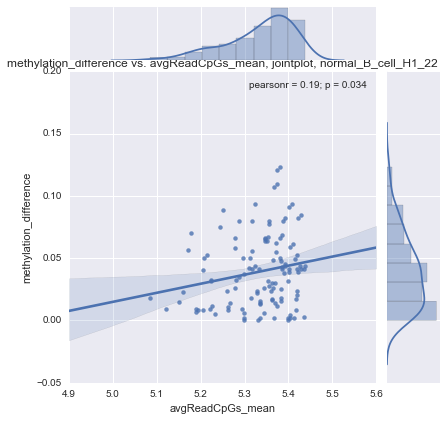

In [88]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=pairs5e, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, normal_B_cell_H1_22")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


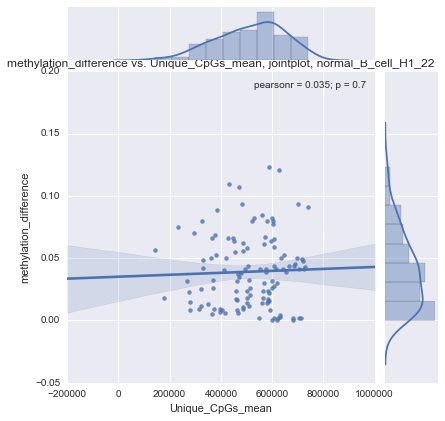

In [89]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=pairs5e, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, normal_B_cell_H1_22")

In [90]:
pairs['type'] = str('CLL')
pairs1a['type'] = str('CLL')
pairs2['type'] = str('CLL')
pairs2a['type'] = str('CLL')
pairs2b['type'] = str('CLL')
pairs3['type'] = str('CLL')
pairs3a['type'] = str('normal')
pairs3b['type'] = str('normal')
pairs3c['type'] = str('normal')
pairs4['type'] = str('normal')
pairs4a['type'] = str('normal')
pairs4b['type'] = str('normal')
pairs4c['type'] = str('normal')
pairs5['type'] = str('normal')
pairs5a['type'] = str('normal')
pairs5b['type'] = str('normal')
pairs5c['type'] = str('normal')
pairs5d['type'] = str('normal')
pairs5e['type'] = str('normal')

frames22 = [pairs, pairs2, pairs3, pairs4]
total_pairs = pd.concat(frames22)
y = total_pairs.methylation_difference # dependent variable
X = total_pairs.drop(['methylation', 'methylation_difference', 'total_reads_mean', 'filename'], axis=1)

categorical_variables = ['type']
for variable in categorical_variables:
    # Fill missing data with the word "Missing"
    X[variable].fillna("Missing", inplace=True)
    # Create array of dummies
    dummies = pd.get_dummies(X[variable], prefix=variable)
    # Update X to include dummies and drop the main variable
    X = pd.concat([X, dummies], axis=1)
    X.drop([variable], axis=1, inplace=True)
    
X = X.drop(['type_normal'], axis=1)
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print("Regression results, all batches 'Normal B' vs 'CLL' , predict \delta methylation")
est.summary()

Regression results, all batches 'Normal B' vs 'CLL' , predict \delta methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     methylation_difference   R-squared:                       0.243
Model:                                OLS   Adj. R-squared:                  0.239
Method:                     Least Squares   F-statistic:                     57.86
Date:                    Thu, 07 Jul 2016   Prob (F-statistic):           2.31e-42
Time:                            17:32:29   Log-Likelihood:                 1609.1
No. Observations:                     726   AIC:                            -3208.
Df Residuals:                         721   BIC:                            -3185.
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const               -0.6069      0.138     -4.394      0.000        -0.878    -0.336
avgReadCpGs_mean     0.0790      0.012      6.481      0.000         0.055     0.103
Unique_CpGs_mean -5.281e-08   4.31e-09    -12.242      0.000     -6.13e-08 -4.43e-08
bsRate_mean          0.2436      0.091      2.677      0.008         0.065     0.422
type_CLL             0.0025      0.003      0.757      0.449        -0.004     0.009
==============================================================================
Omnibus:                       86.850   Durbin-Watson:                   1.273
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              128.909
Skew:                           0.833   Prob(JB):                     1.02e-28
Kurtosis:                       4.220   Cond. No.                     9.50e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.5e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


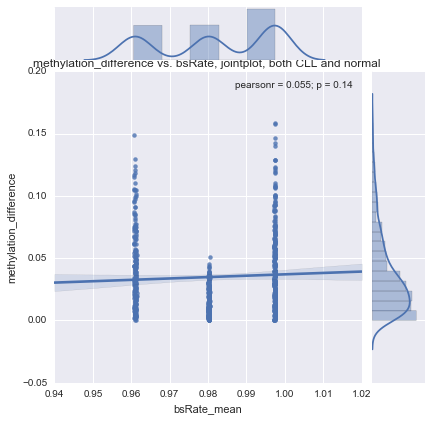

In [91]:
sns.jointplot(x="bsRate_mean", y="methylation_difference",  data=total_pairs, kind="reg")
plt.title("methylation_difference vs. bsRate, jointplot, both CLL and normal ")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


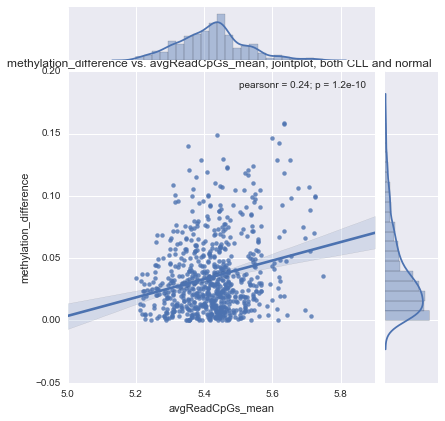

In [92]:
sns.jointplot(x="avgReadCpGs_mean", y="methylation_difference",  data=total_pairs, kind="reg")
plt.title("methylation_difference vs. avgReadCpGs_mean, jointplot, both CLL and normal ")

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


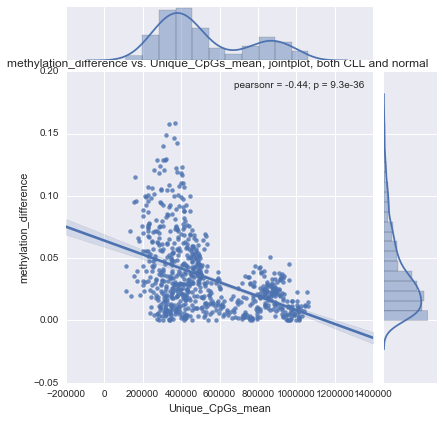

In [93]:
sns.jointplot(x="Unique_CpGs_mean", y="methylation_difference",  data=total_pairs, kind="reg")
plt.title("methylation_difference vs. Unique_CpGs_mean, jointplot, both CLL and normal ")

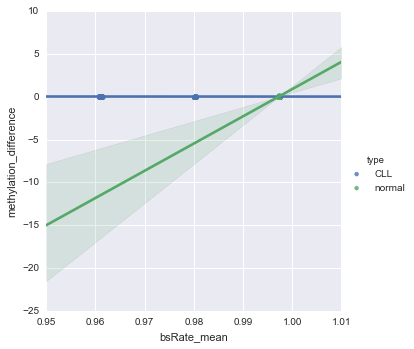

In [94]:
sns.lmplot(x="bsRate_mean", y="methylation_difference",  data=total_pairs, hue='type')

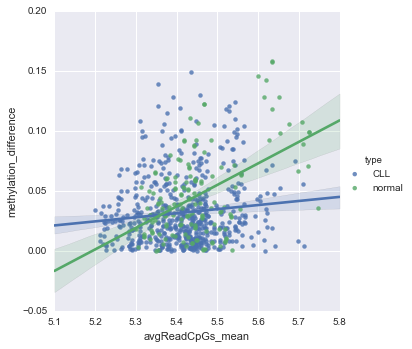

In [95]:
sns.lmplot(x="avgReadCpGs_mean", y="methylation_difference",  data=total_pairs, hue='type')

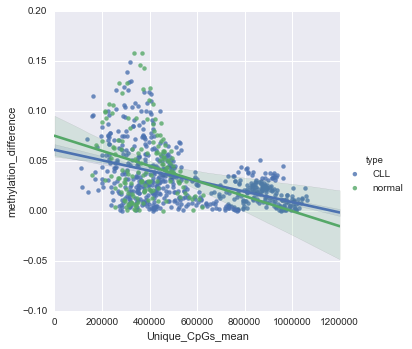

In [96]:
sns.lmplot(x="Unique_CpGs_mean", y="methylation_difference",  data=total_pairs, hue='type')

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:8: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


Random Forest model score is 0.916072389867


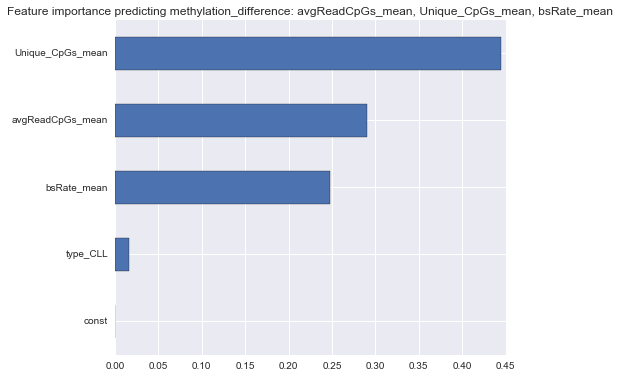

In [97]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score

model = RandomForestRegressor(n_estimators=1000, oob_score=True, random_state=36)
model.fit(X, y)
# Simple version that shows all of the variables
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.sort()
feature_importances.plot(kind="barh", figsize=(7,6))
plt.title("Feature importance predicting methylation_difference: avgReadCpGs_mean, Unique_CpGs_mean, bsRate_mean")
print(str("Random Forest model score is ") + str(model.score(X,y)))